In [55]:
import pandas as pd
import numpy as np
#import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [39]:
data = pd.read_csv('final_dataset.csv')

# Remove first 3 matchweeks
data = data[data.MW > 3]

data.drop(['Unnamed: 0','HomeTeam', 'AwayTeam', 'Date', 'MW', 'HTFormPtsStr', 'ATFormPtsStr', 'FTHG', 'FTAG',
           'HTGS', 'ATGS', 'HTGC', 'ATGC','HomeTeamLP', 'AwayTeamLP','DiffPts','HTFormPts','ATFormPts',
           'HM4','HM5','AM4','AM5','HTLossStreak5','ATLossStreak5','HTWinStreak5','ATWinStreak5',
           'HTWinStreak3','HTLossStreak3','ATWinStreak3','ATLossStreak3'],1, inplace=True)


# Preview data.
display(data.head())

,FTR,HTP,ATP,HM1,HM2,HM3,AM1,AM2,AM3,HTGD,ATGD,DiffFormPts,DiffLP
30,H,1.25,1.00,D,D,W,D,W,L,0.50,0.25,0.25,-16.0
31,NH,0.75,0.25,L,L,W,D,L,L,-0.50,-0.75,0.50,-2.0
32,H,1.00,1.00,L,D,W,D,W,L,0.00,0.25,0.00,-3.0
33,NH,0.75,0.50,L,L,W,D,L,D,-0.25,-0.25,0.25,3.0
34,NH,1.00,1.50,D,L,W,W,W,L,0.00,0.75,-0.50,3.0


In [40]:
# Total number of students.
n_matches = data.shape[0]

# Calculate number of features.
n_features = data.shape[1] - 1

# Calculate matches won by home team.
n_homewins = len(data[data.FTR == 'H'])

# Calculate win rate for home team.
win_rate = (float(n_homewins) / (n_matches)) * 100

# Print the results
print ("Total number of matches: {}".format(n_matches))
print( "Number of features: {}".format(n_features))
print ("Number of matches won by home team: {}".format(n_homewins))
print ("Win rate of home team: {:.2f}%".format(win_rate))

Total number of matches: 5600
Number of features: 12
Number of matches won by home team: 2603
Win rate of home team: 46.48%


C:\Users\Hala\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """


array([[<AxesSubplot:xlabel='HTGD', ylabel='HTGD'>,
        <AxesSubplot:xlabel='ATGD', ylabel='HTGD'>,
        <AxesSubplot:xlabel='HTP', ylabel='HTGD'>,
        <AxesSubplot:xlabel='ATP', ylabel='HTGD'>,
        <AxesSubplot:xlabel='DiffFormPts', ylabel='HTGD'>,
        <AxesSubplot:xlabel='DiffLP', ylabel='HTGD'>],
       [<AxesSubplot:xlabel='HTGD', ylabel='ATGD'>,
        <AxesSubplot:xlabel='ATGD', ylabel='ATGD'>,
        <AxesSubplot:xlabel='HTP', ylabel='ATGD'>,
        <AxesSubplot:xlabel='ATP', ylabel='ATGD'>,
        <AxesSubplot:xlabel='DiffFormPts', ylabel='ATGD'>,
        <AxesSubplot:xlabel='DiffLP', ylabel='ATGD'>],
       [<AxesSubplot:xlabel='HTGD', ylabel='HTP'>,
        <AxesSubplot:xlabel='ATGD', ylabel='HTP'>,
        <AxesSubplot:xlabel='HTP', ylabel='HTP'>,
        <AxesSubplot:xlabel='ATP', ylabel='HTP'>,
        <AxesSubplot:xlabel='DiffFormPts', ylabel='HTP'>,
        <AxesSubplot:xlabel='DiffLP', ylabel='HTP'>],
       [<AxesSubplot:xlabel='HTGD', ylabel='AT

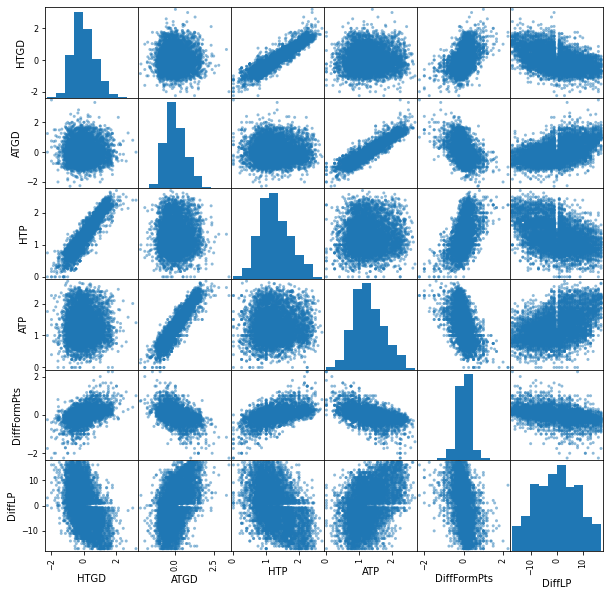

In [41]:
# Visualising distribution of data
from pandas.tools.plotting import scatter_matrix


scatter_matrix(data[['HTGD','ATGD','HTP','ATP','DiffFormPts','DiffLP']], figsize=(10,10))

## Preparing the Data

In [42]:

# Separate into feature set and target variable
X_all = data.drop(['FTR'],1)
y_all = data['FTR']

# Standardising the data.
from sklearn.preprocessing import scale


cols = [['HTGD','ATGD','HTP','ATP','DiffLP']]
for col in cols:
    X_all[col] = scale(X_all[col])

In [43]:
X_all.HM1 = X_all.HM1.astype('str')
X_all.HM2 = X_all.HM2.astype('str')
X_all.HM3 = X_all.HM3.astype('str')
X_all.AM1 = X_all.AM1.astype('str')
X_all.AM2 = X_all.AM2.astype('str')
X_all.AM3 = X_all.AM3.astype('str')

def preprocess_features(X):
    ''' Preprocesses the football data and converts catagorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
                    
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print ("Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

Processed feature columns (24 total features):
['HTP', 'ATP', 'HM1_D', 'HM1_L', 'HM1_W', 'HM2_D', 'HM2_L', 'HM2_W', 'HM3_D', 'HM3_L', 'HM3_W', 'AM1_D', 'AM1_L', 'AM1_W', 'AM2_D', 'AM2_L', 'AM2_W', 'AM3_D', 'AM3_L', 'AM3_W', 'HTGD', 'ATGD', 'DiffFormPts', 'DiffLP']


In [44]:
# Show the feature information by printing the first five rows
print ("\nFeature values:")
X_all.head()


Feature values:


,HTP,ATP,HM1_D,HM1_L,HM1_W,HM2_D,HM2_L,HM2_W,HM3_D,HM3_L,...,AM2_D,AM2_L,AM2_W,AM3_D,AM3_L,AM3_W,HTGD,ATGD,DiffFormPts,DiffLP
30,-0.043829,-0.611968,1,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0.753719,0.355995,0.25,-1.989216
31,-1.120644,-2.238746,0,1,0,0,1,0,0,0,...,0,1,0,0,1,0,-0.737082,-1.138834,0.50,-0.248963
32,-0.582236,-0.611968,0,1,0,1,0,0,0,0,...,0,0,1,0,1,0,0.008318,0.355995,0.00,-0.373267
33,-1.120644,-1.696487,0,1,0,0,1,0,0,0,...,0,1,0,1,0,0,-0.364382,-0.391419,0.25,0.372556
34,-0.582236,0.472551,1,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0.008318,1.103409,-0.50,0.372556


# Simple modeling

In [45]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

C:\Users\Hala\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


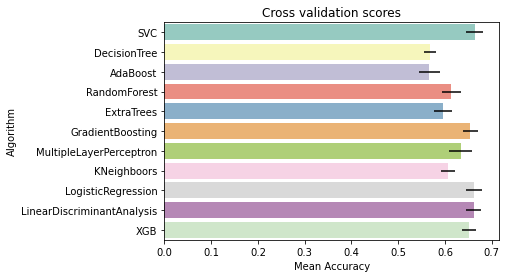

In [50]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(xgb.XGBClassifier())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_all, y_all, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis", "XGB"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

## Hyperparameter tunning for best models

In [52]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_all, y_all)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 23.4min
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed: 42.4min finished


0.6655357142857142

In [53]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_all,y_all)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   53.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  4.3min finished


0.6603571428571429

## Plot learning curves

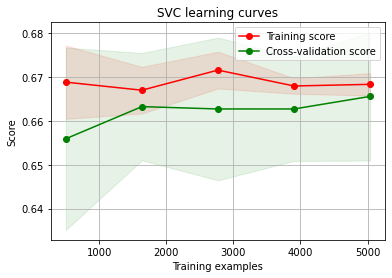

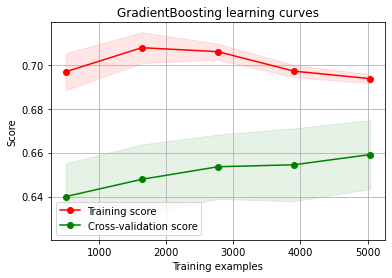

In [56]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_all,y_all,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_all,y_all,cv=kfold)